In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [545]:
from pathlib import Path
import sqlite3
import zlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyteomics import mass
from pyteomics.mzml import MzML
from scipy import signal, special, stats

from src.diascope.parse import parse_spectra
from src.diascope.helpers import array_unpack

In [185]:
DATA_DIR = Path().resolve().parent.joinpath("tests", "data")
DIA_PATH = DATA_DIR.joinpath("211018_S80.dia")

MASS_ACCURACY = 10

In [186]:
def calc_ppm(m_theo, m_obs):
    """
    Calculate parts-per-million (ppm) mass error.
    m_theo = the theoretical m/z of the ion
    m_obs = the m/z observed in the mass spectrum
    """
    return (np.abs(m_theo - m_obs)/m_theo) * 10**6

In [187]:
def calc_peptide_mass(sequence, charge):
    return mass.calculate_mass(sequence=sequence, charge=charge)

In [188]:
dia_connection = sqlite3.connect(DIA_PATH)
dia_spectra = pd.read_sql_query(sql="SELECT * FROM spectra;", con=dia_connection)
# dia_precursor = pd.read_sql_query(sql="SELECT * FROM precursor;", con=dia_connection)

In [189]:
enolase_peptides = pd.read_csv(DATA_DIR.joinpath("enolase_target_list.csv"))
enolase_peptides = enolase_peptides[~enolase_peptides["Transition"].str.contains("precursor")].reset_index(drop=True)
# enolase_peptides = enolase_peptides[enolase_peptides["Transition"] == "precursor+++"].reset_index(drop=True)

In [190]:
# enolase_peptides.to_csv(DATA_DIR.joinpath("enolase_target_list_precursors.csv"), index=None)

In [191]:
# enolase_peptides = enolase_peptides[enolase_peptides["Peptide"] == "SVYDSRGNPTVEVELTTEK"].reset_index(drop=True)
enolase_peptides = enolase_peptides[enolase_peptides["Peptide"] == "AAQDSFAAGWGVMVSHR"].reset_index(drop=True)

In [192]:
# enolase_peptides = enolase_peptides[enolase_peptides["Transition"].isin(set(["E - y8+", "P - y11++"]))].reset_index(drop=True)

In [193]:
# Divide by 60 because its in seconds
retention_times = dia_spectra["ScanStartTime"].unique()/60
ions = enolase_peptides["Transition"].apply(lambda t: t.split(" - ")[1]).values
ion_intensities = np.zeros((enolase_peptides.shape[0], retention_times.shape[0]))

In [194]:
time2index = {}
for i, t in enumerate(retention_times):
    time2index[t] = i
ion2index = {}
for i, ion in enumerate(ions):
    ion2index[ion] = i

In [195]:
for ion_index in enolase_peptides.index:
    precursor_mz = enolase_peptides.loc[ion_index, "Precursor Mz"]
    product_mz = enolase_peptides.loc[ion_index, "Product Mz"]
    filtered_spectra = dia_spectra[(precursor_mz >= dia_spectra["IsolationWindowLower"]) & (precursor_mz <= dia_spectra["IsolationWindowUpper"])]

    for t_i in filtered_spectra.index:
        # Get the mass and the intensity array (zlib compressed and byte encoded)
        mass_arr = array_unpack(zlib.decompress(filtered_spectra.loc[t_i, "MassArray"]), format_character='d').reshape(-1)
        intensity_arr = array_unpack(zlib.decompress(filtered_spectra.loc[t_i, "IntensityArray"]), format_character='f').reshape(-1)
        # Get indices where the mass to charge is within tolerance
        indices = np.where(calc_ppm(m_theo=product_mz, m_obs=mass_arr) < MASS_ACCURACY)
        if isinstance(indices, tuple) and indices[0].size > 0:
            index = indices[0][0]
            scan_start_time = filtered_spectra.loc[t_i, "ScanStartTime"]/60
            time_index = time2index.get(scan_start_time)
            ion_intensities[ion_index][time_index] = intensity_arr[index]
    
# Remove rows and columns that are all zero
keep_ions = ~np.all(ion_intensities == 0., axis=1)
keep_times = ~np.all(ion_intensities == 0., axis=0)
ions = ions[keep_ions]
retention_times = retention_times[keep_times]
ion_intensities = ion_intensities[keep_ions, :][:, keep_times]
y_ion_indices = [i for i,ion in enumerate(ions) if "y" in ion]
b_ion_indices = [i for i,ion in enumerate(ions) if "b" in ion]

In [196]:
time2index = {}
for i, t in enumerate(retention_times):
    time2index[t] = i
ion2index = {}
for i, ion in enumerate(ions):
    ion2index[ion] = i

In [197]:
def x_tandem_hyperscore(ion_intensities, y_ion_indices, b_ion_indices):
    return ion_intensities.sum(axis=0) * special.factorial(np.count_nonzero(ion_intensities[y_ion_indices], axis=0)) * special.factorial(np.count_nonzero(ion_intensities[b_ion_indices], axis=0))

In [198]:
def talus_score(ion_intensities, y_ion_indices, b_ion_indices):
#     return (np.median(ion_intensities[y_ion_indices, :], axis=0) * np.exp(np.count_nonzero(ion_intensities[y_ion_indices], axis=0))) \
#             + (np.median(ion_intensities[b_ion_indices, :], axis=0) * np.exp(np.count_nonzero(ion_intensities[b_ion_indices], axis=0)))
    return np.median(ion_intensities[y_ion_indices, :], axis=0) + np.median(ion_intensities[b_ion_indices, :], axis=0)

In [74]:
# score_chromatogram = x_tandem_hyperscore(ion_intensities, y_ion_indices, b_ion_indices)
score_chromatogram = talus_score(ion_intensities, y_ion_indices, b_ion_indices)

In [75]:
peaks, heights = signal.find_peaks(score_chromatogram, height=10**7)
heights = heights["peak_heights"]

In [203]:
target_ion = "y7+"

In [694]:
def thresholding_algo(y, lag_avg, lag_std, threshold, influence_avg, influence_std, avg_func=np.mean, std_func=np.std):
    """
    Brakel, J.P.G. van (2014). "Robust peak detection algorithm using z-scores". Stack Overflow. 
    Available at: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362 
    (version: 2020-11-08).
    """
    signals = np.zeros(y.shape)
    filtered_y_avg = np.array(y)
    filtered_y_std = np.array(y)
    avg_filter = np.zeros(y.shape)
    std_filter = np.zeros(y.shape)
    avg_filter[:, lag_avg-1] = avg_func(y[:, 0:lag_avg], axis=1)
    std_filter[:, lag_std-1] = std_func(y[:, 0:lag_std], axis=1)
    for i in range(max(lag_avg, lag_std), y.shape[1]):
        # If ... else
        cond = np.abs(y[:, i] - avg_filter[:, i-1]) > threshold * std_filter[:, i-1]
        signals[:, i] = np.where(cond & (y[:, i] > avg_filter[:, i-1]), 1, 0)
        filtered_y_avg_update = influence_avg * y[:, i] + (1-influence_avg) * filtered_y_avg[:, i-1]
        filtered_y_std_update = influence_std * y[:, i] + (1-influence_std) * filtered_y_std[:, i-1]
        filtered_y_avg[:, i] = np.where(cond, filtered_y_avg_update, y[:, i])
        filtered_y_std[:, i] = np.where(cond, filtered_y_std_update, y[:, i])
        # Update filters
        avg_filter[:, i] = avg_func(filtered_y_avg[:, (i-lag_avg+1):i+1], axis=1)
        std_filter[:, i] = std_func(filtered_y_std[:, (i-lag_std+1):i+1], axis=1)
    return dict(signals = signals,
                avg_filter = avg_filter,
                std_filter = std_filter)

#     signals = np.zeros(len(y))
#     filtered_y_avg = np.array(y)
#     filtered_y_std = np.array(y)
#     avg_filter = [0]*len(y)
#     std_filter = [0]*len(y)
#     avg_filter[lag_avg-1] = avg_func(y[0:lag_avg])
#     std_filter[lag_std-1] = std_func(y[0:lag_std])
#     for i in range(max(lag_avg, lag_std), len(y)):
#         if abs(y[i] - avg_filter[i-1]) > threshold * std_filter[i-1]:
#             if y[i] > avg_filter[i-1]:
#                 signals[i] = 1
#             else:
#                 signals[i] = -1
#             filtered_y_avg[i] = influence_avg * y[i] + (1-influence_avg) * filtered_y_avg[i-1]
#             filtered_y_std[i] = influence_std * y[i] + (1-influence_std) * filtered_y_std[i-1]
#         else:
#             signals[i] = 0
#             filtered_y_avg[i] = y[i]
#             filtered_y_std[i] = y[i]
#         avg_filter[i] = avg_func(filtered_y_avg[(i-lag_avg+1):i+1])
#         std_filter[i] = std_func(filtered_y_std[(i-lag_std+1):i+1])
#     return dict(signals = np.asarray(signals),
#                 avg_filter = np.asarray(avg_filter),
#                 std_filter = np.asarray(std_filter))

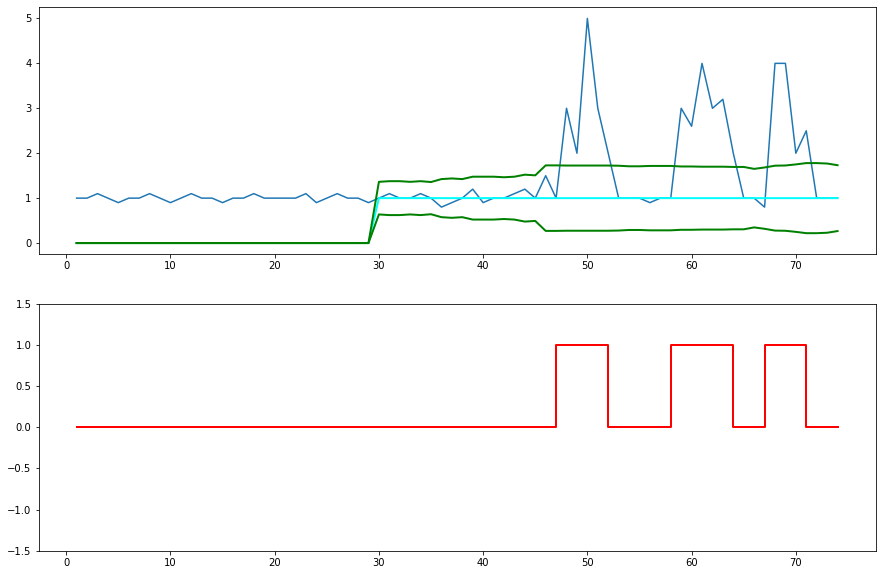

In [693]:
y = np.array([[1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1]])

lag_avg = 30
lag_std = 30
threshold = 6
influence_avg = 0
influence_std = 0

# Run algo with settings from above
result = thresholding_algo(y, 
                           lag_avg=lag_avg, 
                           lag_std=lag_std, 
                           threshold=threshold, 
                           influence_avg=influence_avg, 
                           influence_std=influence_std,
                           avg_func=np.median, 
#                            std_func=stats.median_abs_deviation
                          )

# Plot result
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(np.arange(1, y.shape[1]+1), y.reshape(-1))
ax1.plot(np.arange(1, y.shape[1]+1), result["avg_filter"][0], color="cyan", lw=2)
ax1.plot(np.arange(1, y.shape[1]+1), result["avg_filter"][0] + threshold * result["std_filter"][0], color="green", lw=2)
ax1.plot(np.arange(1, y.shape[1]+1), result["avg_filter"][0] - threshold * result["std_filter"][0], color="green", lw=2)

ax2.step(np.arange(1, y.shape[1]+1), result["signals"][0], color="red", lw=2)
plt.ylim(-1.5, 1.5)
plt.show()

In [396]:
# dx = np.gradient(ion_intensities[ion2index.get(target_ion)], retention_times)
# dxx = np.gradient(dx, retention_times)
# dx = signal.savgol_filter(ion_intensities[ion2index.get(target_ion)], window_length=7, polyorder=2, deriv=1)
# dxx = signal.savgol_filter(ion_intensities[ion2index.get(target_ion)], window_length=11, polyorder=2, deriv=2)
# midpoint = dxx.argmin()
# left = midpoint-1
# right= midpoint+1
# while dx[left] > 0:
#     left -= 1
# while dx[right] < 0:
#     right += 1

In [696]:
ion_intensities.shape

(27, 1342)

In [697]:
threshold = 40
dx = thresholding_algo(
    y=ion_intensities, 
    lag_avg=30,
    lag_std=300,
    threshold=threshold,
    influence_avg=0.1,
    influence_std=0.,
    avg_func=np.mean, 
#     std_func=stats.median_abs_deviation
)

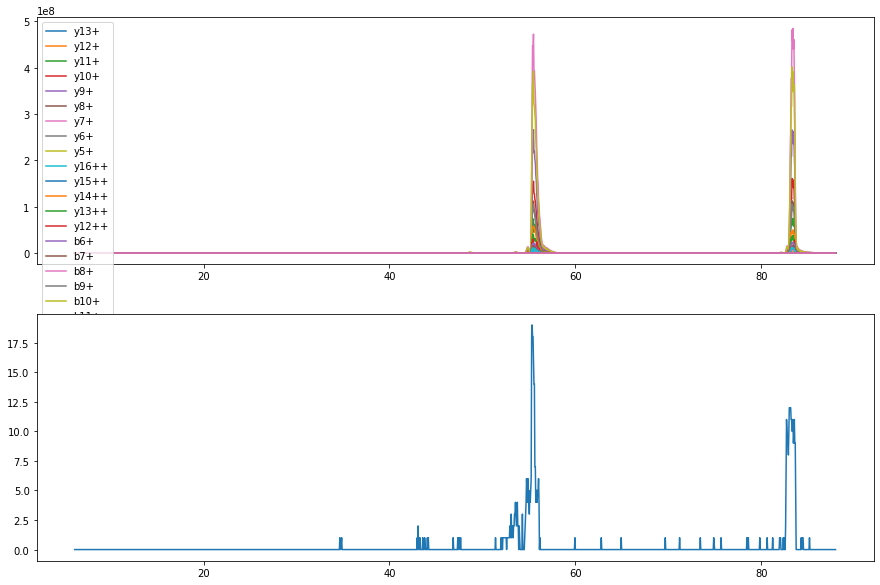

In [705]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
for i in range(ions.shape[0]):
#     if i == ion2index.get(target_ion):
    ax1.plot(retention_times, ion_intensities[i, :], label=ions[i])
#         ax1.scatter(retention_times[midpoint], ion_intensities[i, midpoint])
#         ax1.scatter(retention_times[left], ion_intensities[i, left])
#         ax1.scatter(retention_times[right], ion_intensities[i, right])
#     ax1.plot(retention_times, dx["avg_filter"][i])
#     ax1.plot(retention_times, dx["avg_filter"][i] + threshold * dx["std_filter"][i])
#     ax1.plot(retention_times, dx["avg_filter"][i] - threshold * dx["std_filter"][i])
#     ax2.plot(retention_times, dx["signals"][i])
ax2.plot(retention_times, dx["signals"].sum(axis=0))
# ax1.plot(retention_times, sdxx)
# ax2.plot(retention_times, score_chromatogram)
# ax2.scatter(retention_times[peaks], heights)
ax1.legend()
plt.show()

In [24]:
# test_chromatograms = pd.read_table(DATA_DIR.joinpath("enolase_target_list_chromatograms.tsv"))
test_chromatograms = pd.read_table("~/Downloads/test_chromatograms.tsv")

In [25]:
test_chromatograms["Times"] = test_chromatograms["Times"].apply(lambda t: list(map(float, t.split(","))))
test_chromatograms["Intensities"] = test_chromatograms["Intensities"].apply(lambda i: list(map(float, i.split(","))))

In [26]:
indices, heights = signal.find_peaks(test_chromatograms.loc[13, "Intensities"], height=10**6)
heights = heights["peak_heights"]

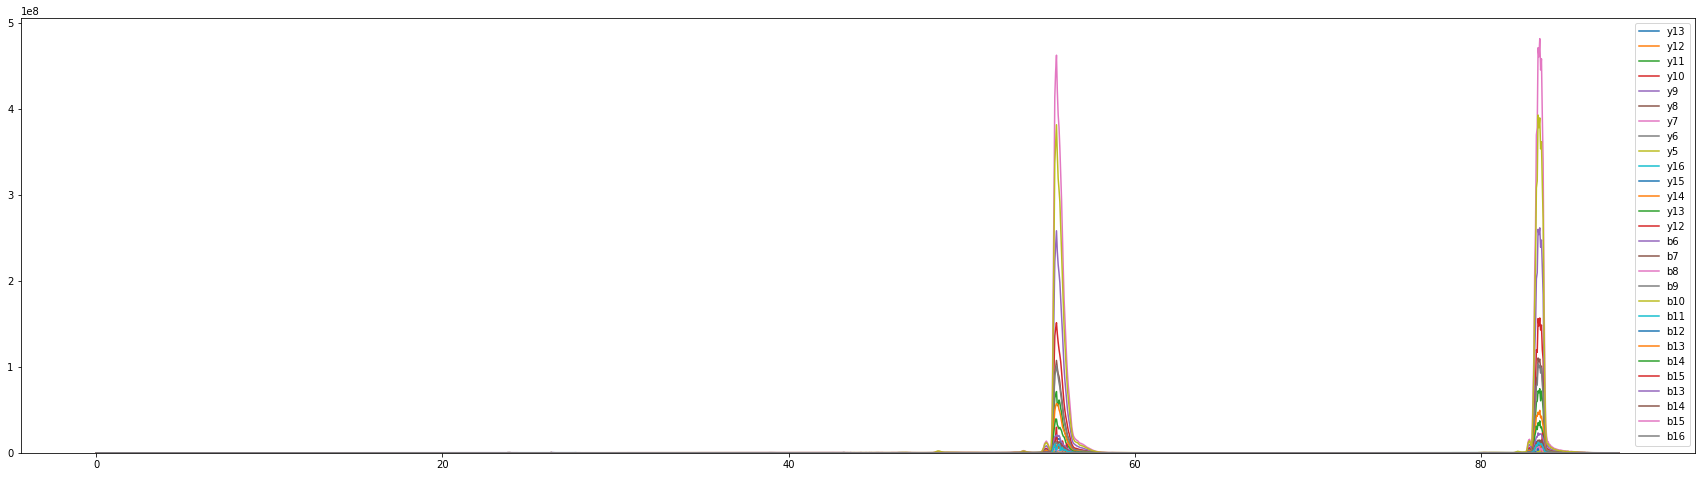

In [27]:
res = []
plt.figure(figsize=(30, 8))
for i, row in test_chromatograms[test_chromatograms["PeptideModifiedSequence"] == "AAQDSFAAGWGVMVSHR"].iterrows():
    res.append((row["FragmentIon"], max(row["Intensities"]),))
    plt.plot(row["Times"], row["Intensities"], label=row["FragmentIon"])
# plt.plot(test_chromatograms.loc[13, "Times"], test_chromatograms.loc[13, "Intensities"])
# plt.scatter(np.array(test_chromatograms.loc[13, "Times"])[indices], heights)
plt.ylim(ymin=0)
plt.legend()
plt.show()